# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Импортирование необходимых библиотек


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.pipeline import  make_pipeline
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
# pd.set_option('max_columns', 800) 

# 1. Подготовка данных

In [2]:
test_frame = pd.read_csv("gold_recovery_test.csv")
train_frame = pd.read_csv("gold_recovery_train.csv")
full_frame = pd.read_csv("gold_recovery_full.csv")

In [3]:
# train_frame = train_frame.fillna(1e-100)

In [4]:
train_frame = train_frame.replace(float("-inf"),0)

In [5]:
train_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
def apply_recovery(row):
    (input_au,
     output_au,
     output_tail) = (row["rougher.input.feed_au"],
                     row["rougher.output.concentrate_au"],
                     row["rougher.output.tail_au"])
    recovery_metric = (((output_au) * ((input_au) - (output_tail)))/
                       (((input_au) * ((output_au) - (output_tail))))) * 100
    return recovery_metric

In [7]:
test = train_frame.dropna(subset = ["rougher.input.feed_au",
                                    "rougher.output.concentrate_au",
                                    "rougher.output.tail_au",
                                    "rougher.output.recovery"],axis = 0).apply(
                                                                        apply_recovery,axis = 1)

In [8]:
MAE(train_frame.dropna(subset = ["rougher.input.feed_au",
                                    "rougher.output.concentrate_au",
                                    "rougher.output.tail_au",
                                    "rougher.output.recovery"])["rougher.output.recovery"],
                       test)

9.444891926100695e-15

recovery в train рассчитаны верно 

In [9]:
import collections
step = collections.Counter()
type_step = collections.Counter()
data = collections.Counter()
list_columns = [i for i in train_frame.columns if i not in test_frame.columns]
for i in list_columns:
    words = list(map(str,i.split(".")))
    step[words[0]] += 1
    type_step[words[1]] += 1
    data[words[2]] += 1
    

In [10]:
list_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [11]:
step,"\n",type_step,"\n",data

(Counter({'final': 9,
          'primary_cleaner': 8,
          'rougher': 13,
          'secondary_cleaner': 4}),
 '\n',
 Counter({'output': 30, 'calculation': 4}),
 '\n',
 Counter({'concentrate_ag': 3,
          'concentrate_pb': 3,
          'concentrate_sol': 3,
          'concentrate_au': 3,
          'recovery': 2,
          'tail_ag': 4,
          'tail_pb': 4,
          'tail_sol': 4,
          'tail_au': 4,
          'sulfate_to_au_concentrate': 1,
          'floatbank10_sulfate_to_au_feed': 1,
          'floatbank11_sulfate_to_au_feed': 1,
          'au_pb_ratio': 1}))

Заметим, что из 34 пропущенных признака 30 относятся к параметрам продукта и только 4 к рассчетным характеристикам  

1. 9 пропущенных признаков этапа final, 8 primary_cleaner, 9 rougher, 4 secondary_cleaner относятся к параметрам продукта
1. 4 пропущенных признака этапа rougher относятся к рассчетным характеристикам
1. На всех этапах отсутсвует информация о хвостовых частях
1. Во всех этапах, кроме повтороной очистки отсутсвует информация о доле металлов 
1. У финального этапа и этапа флотации отсутсвуют признаки обогащения
1. Так же остутсвуют данные о некоторых реогентах на этапе флотации


проверим можем ли мы востановить згначения обогащения

In [12]:
# index_notnull_params = list(train_frame.dropna(subset=["rougher.input.feed_au",
#                                     "rougher.output.concentrate_au",
#                                     "rougher.output.tail_au",
#                                     "rougher.output.recovery"]).index)
# index_notnull_recovery = list(train_frame.dropna(subset = ["rougher.output.recovery"]).index)

In [13]:
imputer = KNNImputer()
without_nan = pd.DataFrame(data = imputer.fit_transform(train_frame.drop(['date'],axis = 1)),
             columns= train_frame.drop(['date'],axis = 1).columns,
             index = train_frame.drop(['date'],axis = 1).index)

In [14]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1*(q75-q25)
    second_part=q75+1*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [15]:
# without_nan_nan

In [16]:
# for column in without_nan.columns:
#     indexes = remove_ouliers(without_nan,column)
#     without_nan.drop(indexes,axis = 0,inplace = True)
# for column in without_nan.columns:
#     plt.boxplot(without_nan[column])
#     plt.show()

# 2. Анализ данных

In [31]:
print("Концентрация после флотации")
print("Коцентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["rougher.output.concentrate_ag"].mean(),
without_nan["rougher.output.concentrate_pb"].mean(),
without_nan["rougher.output.concentrate_au"].mean()))
print()
print("Концентрация после первичной очистки")
print("Коцентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["primary_cleaner.output.concentrate_ag"].mean(),
without_nan["primary_cleaner.output.concentrate_pb"].mean(),
without_nan["primary_cleaner.output.concentrate_au"].mean()))
print()
print("Концентрация поле вторичной очистки")
print("Коцентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["final.output.concentrate_ag"].mean(),
without_nan["final.output.concentrate_pb"].mean(),
without_nan["final.output.concentrate_au"].mean()))

Концентрация после флотации
Коцентрация Серебра: 10.55,Свинца: 6.86,Золота: 17.34

Концентрация после первичной очистки
Коцентрация Серебра: 7.40,Свинца: 8.53,Золота: 29.05

Концентрация поле вторичной очистки
Коцентрация Серебра: 4.71,Свинца: 9.10,Золота: 39.40


По представленным выше даннным отчетливо видно, что с каждым этапом увеличивается концентрация золата и свинца, так же можо заметить уменьшение концентрации серебра

Размер гранул поступащих на этап флотации в тренировочной выборке
Среднне 58.52
Медиана 53.97

Размер гранул поступащих на этап флотации в тестовой выборке
Среднее 55.94
Медиана 50.0


(0.0, 200.0)

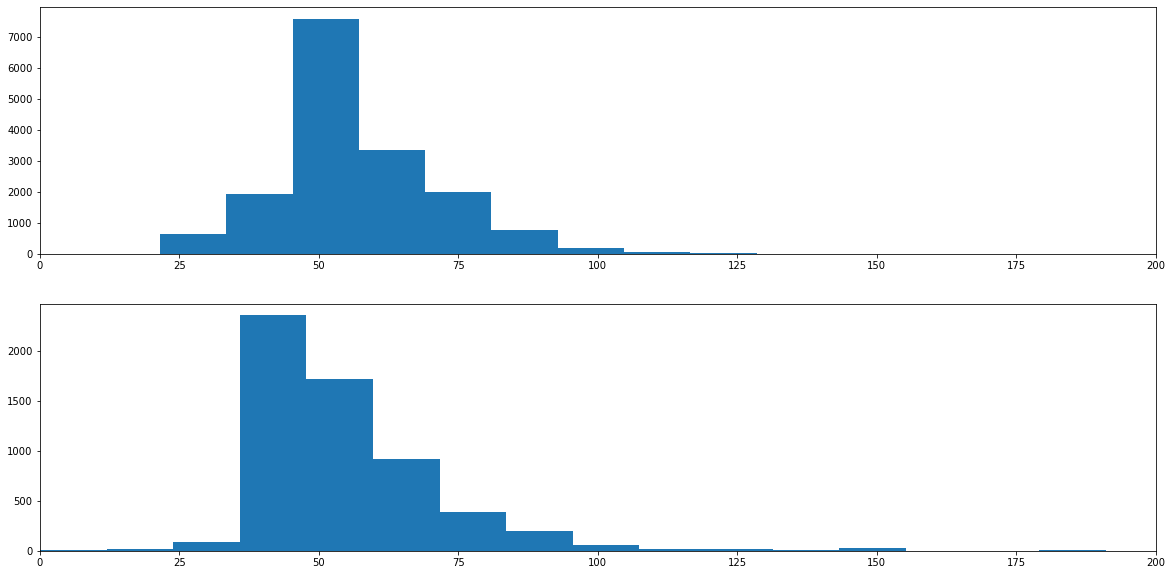

In [63]:
fig,ax = plt.subplots(2,1,figsize = (20,10))
print("Размер гранул поступащих на этап флотации в тренировочной выборке")
print("Среднне",round(without_nan["rougher.input.feed_size"].mean(),2))
print("Медиана",round(without_nan["rougher.input.feed_size"].median(),2))
print()
print("Размер гранул поступащих на этап флотации в тестовой выборке")
print("Среднее",round(test_frame["rougher.input.feed_size"].mean(),2))
print("Медиана",round(test_frame["rougher.input.feed_size"].median(),2))
ax[0].hist(without_nan["rougher.input.feed_size"],bins = 40)
ax[1].hist(test_frame["rougher.input.feed_size"],bins = 40)
ax[0].set_xlim(0,200)
ax[1].set_xlim(0,200)

Мы можем видеть, что распределения немного отличаются. В тренеровчной выборке преобладают значения около порога 50 и выше, в то же время как в тестовой выборке достаточно большое количество объектов сконцентрированы до порога 50. Так же это заметно и на средних значениях, среднее значение тренеровочной выборки на 3 пункта больше среднего по тестовой выборке

In [77]:
def summary_of_concentarution(row):
    list_of_steps = ["rougher","primary_cleaner","final"]
    input_feed_au = row["rougher.input.feed_au"]
    input_feed_ag = row["rougher.input.feed_ag"]
    input_feed_pb = row["rougher.input.feed_pb"]
    input_feed_sol = row["rougher.input.feed_sol"]
    out_rougher = []
    out_primary_cleaner = []
    out_final = []
    list_of_arrays =[out_rougher,out_primary_cleaner,out_final]
    for step,array in zip(list_of_steps,list_of_arrays):
        array.append(row[step+".output.concentrate_au"])
        array.append(row[step+".output.concentrate_ag"])
        array.append(row[step+".output.concentrate_pb"])
        array.append(row[step+".output.concentrate_sol"])
    sum_before_steps = input_feed_ag+input_feed_au+input_feed_pb+input_feed_sol
    sum_rougher = sum(out_rougher)
    sum_primary = sum(out_primary_cleaner)
    sum_final = sum(out_final)
    return pd.Series([sum_before_steps,sum_rougher,sum_primary,sum_final])
    

In [109]:
sum_values = without_nan.apply(summary_of_concentarution,axis = 1)
sum_values.columns = ["before_rougher","rougher","primary_cleaner","final"]

In [110]:
sum_values

,before_rougher,rougher,primary_cleaner,final
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
16855,53.415050,70.781325,59.001692,68.098589
16856,53.696482,70.539603,59.703912,68.274362
16857,54.589604,55.376330,59.561096,68.226068
16858,54.027355,69.201689,57.216686,68.200449


In [111]:
sum_values.query("before_rougher == 0")

,before_rougher,rougher,primary_cleaner,final


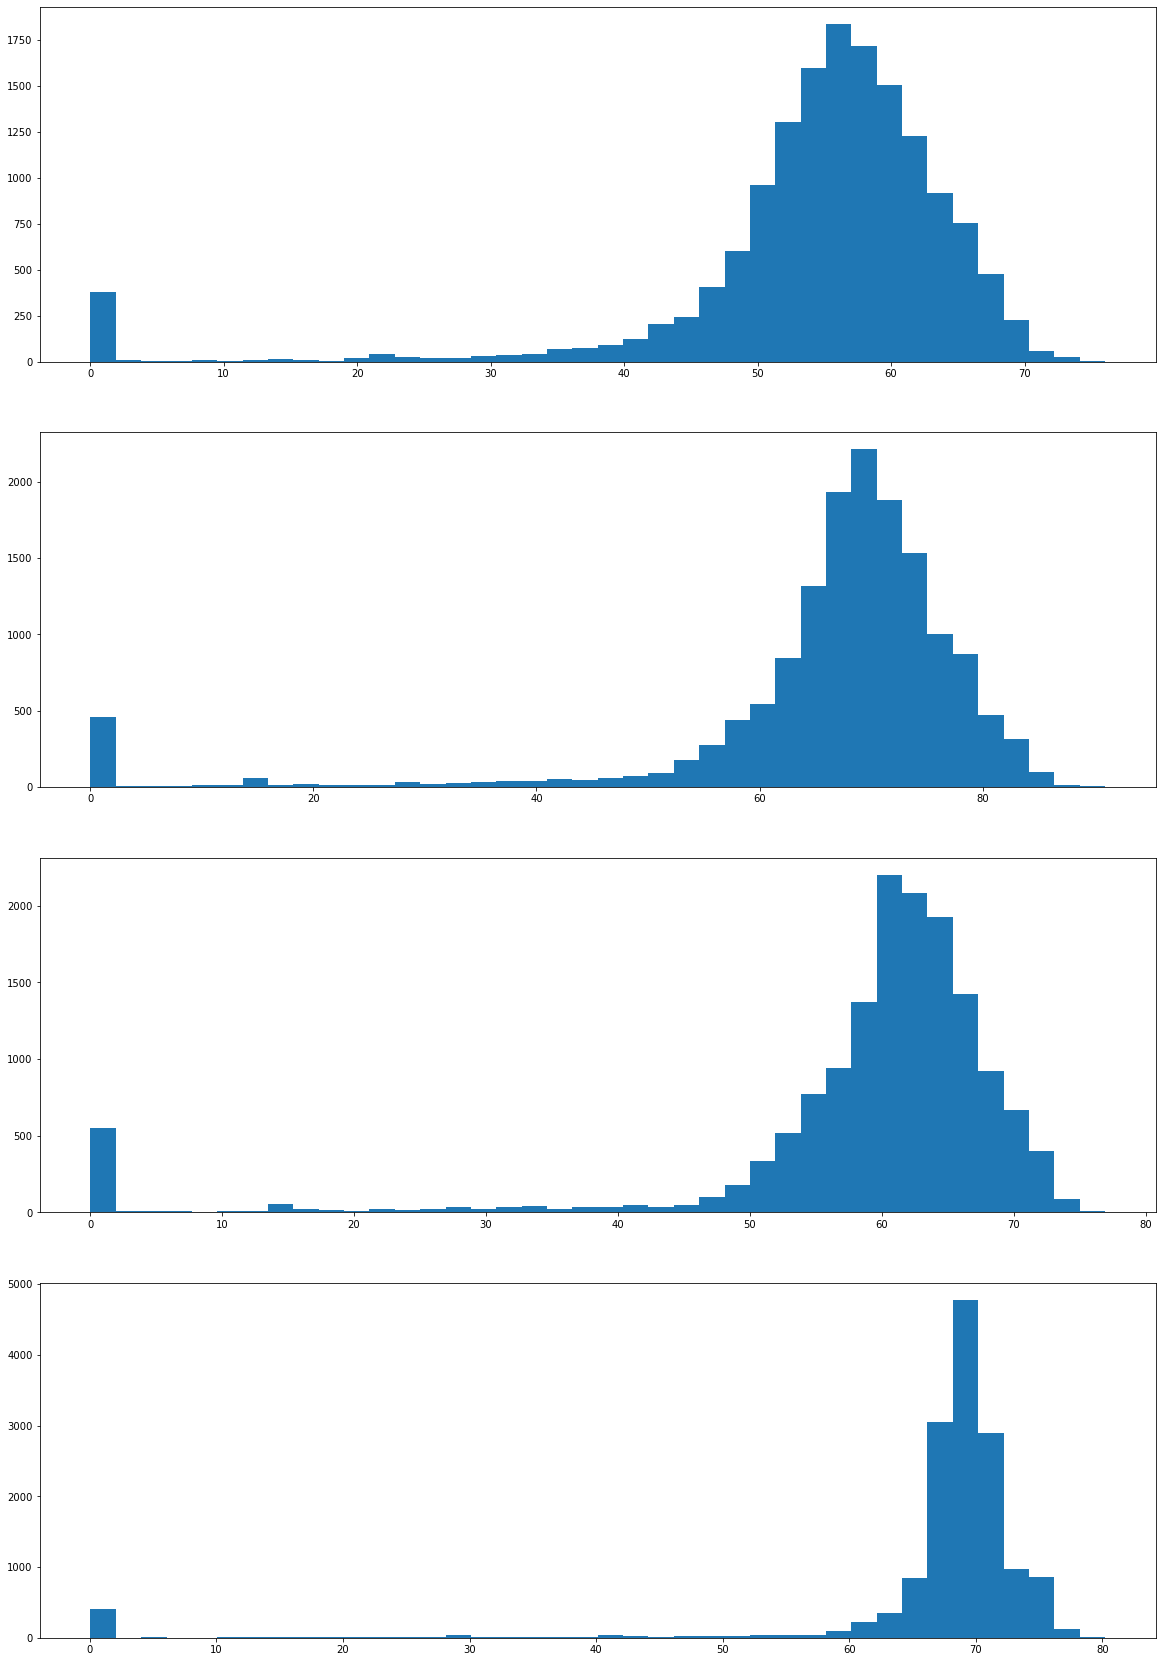

In [112]:
fig,ax = plt.subplots(4,1,figsize = (20,30))

ax[0].hist(sum_values["before_rougher"],bins = 40)
ax[1].hist(sum_values["rougher"],bins = 40)
ax[2].hist(sum_values["primary_cleaner"],bins = 40)
ax[3].hist(sum_values["final"],bins = 40)
plt.show()

Можно заметить, что во всех распределениях присутсвует пик около нулевого значения. Он очень далек от общего распределения, его следует удалить

In [108]:
without_nan.shape

(15074, 86)

In [94]:
without_nan[without_nan["rougher.input.feed_au"] == 0]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,0.0,0.0,0.0,0.0,51.594859,0.0,0.0,0.0,0.0,2.116168,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,0.0,0.0,0.0,0.0,87.476755,0.0,0.0,0.0,0.0,27.474557,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,28.838364,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,28.124272,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,31.959129,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12052,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,36.048913,...,20.005303,-500.893527,14.922286,-500.230461,10.909829,-500.314837,9.007956,-500.153163,10.988968,-500.387261
12053,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,36.201845,...,19.962859,-655.489381,14.956567,-524.758657,10.961487,-500.066426,9.004925,-500.040902,10.961121,-500.023096
12054,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,36.048913,...,20.017100,-523.801393,15.013965,-499.995375,10.991333,-499.941268,9.062215,-499.992738,10.996987,-499.871678
12055,0.0,0.0,0.0,0.0,94.851472,0.0,0.0,0.0,0.0,36.048913,...,19.947963,-521.792599,15.041185,-500.303435,10.980523,-500.095725,9.041985,-499.916563,11.010581,-500.083532


In [107]:
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.input.feed_au"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.input.feed_ag"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.input.feed_pb"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.input.feed_sol"] == 0].index,
                               axis = 0)


without_nan = without_nan.drop(index = without_nan[without_nan["rougher.output.concentrate_au"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.output.concentrate_ag"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.output.concentrate_pb"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["rougher.output.concentrate_sol"] == 0].index,
                               axis = 0)

without_nan = without_nan.drop(index = without_nan[without_nan["primary_cleaner.output.concentrate_au"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["primary_cleaner.output.concentrate_ag"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["primary_cleaner.output.concentrate_pb"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["primary_cleaner.output.concentrate_sol"] == 0].index,
                               axis = 0)

without_nan = without_nan.drop(index = without_nan[without_nan["final.output.concentrate_au"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["final.output.concentrate_ag"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["final.output.concentrate_pb"] == 0].index,
                               axis = 0)
without_nan = without_nan.drop(index = without_nan[without_nan["final.output.concentrate_sol"] == 0].index,
                               axis = 0)


# 3. Модель

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
    - [ ]  Проанализированы и обработаны аномальные значения
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке